### Cifar10 dataset loader


In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


def get_loaders(
    source, batch_size, transform, eval_transform=None, root="data", split_ratio=0.1
):
    if eval_transform is None:
        eval_transform = transform

    trainset = source(
        root=root,
        train=True,
        download=True,
        transform=transform,
    )
    testset = source(
        root=root,
        train=False,
        download=True,
        transform=eval_transform,
    )

    trainset, valset = torch.utils.data.random_split(
        trainset,
        [int((1 - split_ratio) * len(trainset)), int(split_ratio * len(trainset))],
    )

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainloader, valloader, testloader


def get_cifar10_loaders(batch_size, root="data/cifar10", split_ratio=0.1):
    transform = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )
    eval_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ]
    )
    return get_loaders(
        datasets.CIFAR10,
        batch_size,
        transform,
        eval_transform=eval_transform,
        root=root,
        split_ratio=split_ratio,
    )


DATALOADERS = {
    "cifar10": get_cifar10_loaders,
}

if __name__ == "__main__":
    datasets_to_load = ["cifar10"]
    for dataset in datasets_to_load:
        trainloader, valloader, testloader = DATALOADERS[dataset](batch_size=64)
        print(f'{dataset}: {len(trainloader.dataset)}, {len(valloader.dataset)}, {len(testloader.dataset)}, {trainloader.dataset[0][0].shape}')



Files already downloaded and verified
Files already downloaded and verified
cifar10: 45000, 5000, 10000, torch.Size([3, 32, 32])


#### Useful utilities
- ``evaluate(model, loader, criterion, device)`` – Evaluates a model on a dataset, computing loss, accuracy, and confusion matrix.
- ``plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, filename)`` – Plots and saves the training and validation loss/accuracy curves.
- ``save_model(model, filename, verbose, existed)`` – Saves a PyTorch model's state dictionary while handling filename conflicts.
- ``load_model(model, filename, qconfig, fuse_modules, verbose)`` – Loads a saved model, optionally applying quantization and module fusion.
- ``reset_seed(seed)`` – Sets seeds for PyTorch and NumPy to ensure reproducibility.
- ``plot_confusion_matrix(conf_matrix, filename)`` – Generates and saves a heatmap of the confusion matrix for CIFAR-10 classification.



In [2]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
import torch.ao.quantization as tq
from tqdm.notebook import tqdm

DEFAULT_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def evaluate(model, loader, criterion, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0
    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        loop = tqdm(loader, desc="Evaluating", leave=True)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)

            running_loss += loss.item()
            predicted = torch.argmax(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy, conf_matrix


def preprocess_filename(filename: str, existed: str = "keep_both") -> str:
    if existed == "overwrite":
        pass
    elif existed == "keep_both":
        base, ext = os.path.splitext(filename)
        cnt = 1
        while os.path.exists(filename):
            filename = f"{base}-{cnt}{ext}"
            cnt += 1
    elif existed == "raise" and os.path.exists(filename):
        raise FileExistsError(f"{filename} already exists.")
    else:
        raise ValueError(f"Unknown value for 'existed': {existed}")
    return filename


def plot_loss_accuracy(
    train_loss, train_acc, val_loss, val_acc, filename="loss_accuracy.png"
):

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(train_loss, color="tab:blue")
    ax1.plot(val_loss, color="tab:red")
    ax1.legend(["Training", "Validation"])
    ax1.set_title("Loss")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(train_acc, color="tab:blue")
    ax2.plot(val_acc, color="tab:red")
    ax2.legend(["Training", "Validation"])
    ax2.set_title("Accuracy")

    fig.tight_layout()
    filename = preprocess_filename(filename)
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename)
    print(f"Plot saved at {filename}")


def plot_confusion_matrix(conf_matrix, filename="conf_matrix.png"):
    classes = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for CIFAR-10 Classification")
    plt.tight_layout()

    filename = preprocess_filename(filename)
    plt.savefig(filename)
    print(f"Confusion matrix saved to {filename}")


def save_model(
    model, filename: str, verbose: bool = True, existed: str = "keep_both"
) -> None:
    filename = preprocess_filename(filename, existed)

    os.makedirs(os.path.dirname(filename), exist_ok=True)
    torch.save(model.state_dict(), filename)
    if verbose:
        print(f"Model saved at {filename} ({os.path.getsize(filename) / 1e6} MB)")
    else:
        print(f"Model saved at {filename}")


def load_model(
    model, filename: str, qconfig=None, fuse_modules: bool = False, verbose: bool = True
) -> torch.nn.Module:
    if fuse_modules and hasattr(model, "fuse_modules"):
        print("Fusing modules")
        model.fuse_modules()
    else:
        print("Model does not have 'fuse_modules' method. Skipping fusion.")

    if qconfig is not None:
        model = tq.QuantWrapper(model)
        model.qconfig = qconfig
        tq.prepare(model, inplace=True)
        tq.convert(model, inplace=True)

    device = DEFAULT_DEVICE if qconfig is None else "cpu"
    model.load_state_dict(torch.load(filename, map_location=device))

    if verbose:
        print(f"Model loaded from {filename} ({os.path.getsize(filename) / 1e6} MB)")
    return model


def reset_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



### VGG

#### Implement your model based on the given model architecture in the lab material.



In [4]:
import torch
import torch.nn as nn
import torch.ao.quantization as tq


class VGG(nn.Module):
    """ Implement your model here """
    def __init__(self, in_channels=3, in_size=32, num_classes=10) -> None:
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc6 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(inplace=True)
        )

        self.fc7 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True)
        )

        self.fc8 = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)
        return x

    def fuse_modules(self):

        self.eval()
        tq.fuse_modules(self.conv1, [['0', '1', '2']], inplace=True)
        tq.fuse_modules(self.conv2, [['0', '1', '2']], inplace=True)
        tq.fuse_modules(self.conv3, [['0', '1', '2']], inplace=True)
        tq.fuse_modules(self.conv4, [['0', '1', '2']], inplace=True)
        tq.fuse_modules(self.conv5, [['0', '1', '2']], inplace=True)
        tq.fuse_modules(self.fc6, [['0', '1']], inplace=True)
        tq.fuse_modules(self.fc7, [['0', '1']], inplace=True)



if __name__ == "__main__":
    model = VGG()
    inputs = torch.randn(1, 3, 32, 32)
    print(model)

    from torchsummary import summary

    summary(model, (3, 32, 32), device="cpu")


VGG(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

### QConfig
#### Quantization scheme
- Write your QConfig Observer inorder to do PTQ
- Use Power-of-Two uniform/scale, symmetric quantization to quantize model.
- Finish qconfig observer for PTQ calibration.


In [29]:
from enum import Enum
import math

import torch
import torch.ao.quantization as tq


class PowerOfTwoObserver(tq.MinMaxObserver):
    """
    Observer module for power-of-two quantization (dyadic quantization with b = 1).
    """

    def scale_approximate(self, scale: float, max_shift_amount=8) -> float:
        """
        Approximate the scale value to the nearest power-of-two.
        """
        if scale == 0:
            return 0.0
        log2_scale = max(-max_shift_amount, min(round(math.log2(scale)), 0))
        return 2.0 ** log2_scale

    def calculate_qparams(self):
        """Calculates the quantization parameters with scale as power of two."""
        min_val, max_val = self.min_val.item(), self.max_val.item()
        qconfig = {
            torch.qint8: (-127, 127, 0),
            torch.quint8: (0, 255, 128)
        }.get(self.dtype, None)

        if qconfig is None:
            raise ValueError("Unsupported dtype")

        qmin, qmax, zero_point = qconfig
        max_abs = 2 * max(abs(min_val), abs(max_val))
        # avoid to divide 0 or inf
        if max_abs == 0:
            scale = 0
        elif max_abs == float("inf"):
            scale = 1
        else:
            scale = max_abs / (qmax-qmin)
        scale = self.scale_approximate(scale)
        scale = torch.tensor(scale, dtype=torch.float32)
        zero_point = torch.tensor(zero_point, dtype=torch.int64)
        zero_point = torch.clamp(zero_point, qmin, qmax)
        return scale, zero_point


class CustomQConfig(Enum):
    POWER2 = tq.QConfig(
        activation=PowerOfTwoObserver.with_args(
            dtype=torch.quint8, qscheme=torch.per_tensor_symmetric
        ),
        weight=PowerOfTwoObserver.with_args(
            dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
        ),
    )
    DEFAULT = None



### Model Training

- Set hyper parameter for training.
- Record the number of epochs and the accuracy in the results.
- Plot the accuracy and loss.



Files already downloaded and verified
Files already downloaded and verified


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  1/50  lr=1.00e-01, train_loss=1.8446, val_loss=1.8110, train_acc=0.2893, val_acc=0.3508
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  2/50  lr=9.99e-02, train_loss=1.5209, val_loss=1.4898, train_acc=0.4443, val_acc=0.4750
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  3/50  lr=9.96e-02, train_loss=1.3258, val_loss=1.5687, train_acc=0.5343, val_acc=0.4452


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  4/50  lr=9.91e-02, train_loss=1.1902, val_loss=1.4288, train_acc=0.5877, val_acc=0.5640
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  5/50  lr=9.84e-02, train_loss=1.1272, val_loss=1.2539, train_acc=0.6156, val_acc=0.5792
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  6/50  lr=9.76e-02, train_loss=1.0702, val_loss=1.2616, train_acc=0.6395, val_acc=0.5984
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  7/50  lr=9.65e-02, train_loss=1.0191, val_loss=1.3437, train_acc=0.6555, val_acc=0.5566


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  8/50  lr=9.52e-02, train_loss=0.9940, val_loss=1.6177, train_acc=0.6651, val_acc=0.5612


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch  9/50  lr=9.38e-02, train_loss=0.9665, val_loss=1.0860, train_acc=0.6763, val_acc=0.6326
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/50  lr=9.22e-02, train_loss=0.9306, val_loss=1.0882, train_acc=0.6894, val_acc=0.6328
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/50  lr=9.05e-02, train_loss=0.8997, val_loss=1.2485, train_acc=0.7008, val_acc=0.6066


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/50  lr=8.85e-02, train_loss=0.8915, val_loss=1.1446, train_acc=0.7017, val_acc=0.6178


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/50  lr=8.64e-02, train_loss=0.8683, val_loss=1.3512, train_acc=0.7138, val_acc=0.5684


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/50  lr=8.42e-02, train_loss=0.8507, val_loss=1.5074, train_acc=0.7172, val_acc=0.5790


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/50  lr=8.19e-02, train_loss=0.8431, val_loss=0.9481, train_acc=0.7190, val_acc=0.6846
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/50  lr=7.94e-02, train_loss=0.8173, val_loss=0.9104, train_acc=0.7264, val_acc=0.7030
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/50  lr=7.68e-02, train_loss=0.7972, val_loss=0.9882, train_acc=0.7348, val_acc=0.6808


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/50  lr=7.41e-02, train_loss=0.7716, val_loss=0.8549, train_acc=0.7455, val_acc=0.7186
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/50  lr=7.13e-02, train_loss=0.7676, val_loss=1.0860, train_acc=0.7440, val_acc=0.6420


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/50  lr=6.84e-02, train_loss=0.7433, val_loss=0.8193, train_acc=0.7509, val_acc=0.7238
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21/50  lr=6.55e-02, train_loss=0.7125, val_loss=0.8295, train_acc=0.7611, val_acc=0.7278
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22/50  lr=6.24e-02, train_loss=0.6924, val_loss=0.9993, train_acc=0.7670, val_acc=0.6876


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23/50  lr=5.94e-02, train_loss=0.6910, val_loss=0.9879, train_acc=0.7708, val_acc=0.6890


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24/50  lr=5.63e-02, train_loss=0.6536, val_loss=0.8708, train_acc=0.7792, val_acc=0.7150


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25/50  lr=5.31e-02, train_loss=0.6425, val_loss=0.8423, train_acc=0.7830, val_acc=0.7128


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26/50  lr=5.00e-02, train_loss=0.6272, val_loss=0.7054, train_acc=0.7880, val_acc=0.7618
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27/50  lr=4.69e-02, train_loss=0.6048, val_loss=0.7078, train_acc=0.7971, val_acc=0.7606


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28/50  lr=4.37e-02, train_loss=0.5790, val_loss=0.8619, train_acc=0.8034, val_acc=0.7102


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29/50  lr=4.06e-02, train_loss=0.5657, val_loss=0.6006, train_acc=0.8071, val_acc=0.7974
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30/50  lr=3.76e-02, train_loss=0.5382, val_loss=0.8828, train_acc=0.8175, val_acc=0.7238


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31/50  lr=3.45e-02, train_loss=0.5239, val_loss=0.7727, train_acc=0.8224, val_acc=0.7472


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32/50  lr=3.16e-02, train_loss=0.5008, val_loss=0.6695, train_acc=0.8310, val_acc=0.7748


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33/50  lr=2.87e-02, train_loss=0.4768, val_loss=0.6379, train_acc=0.8384, val_acc=0.7830


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34/50  lr=2.59e-02, train_loss=0.4544, val_loss=0.6315, train_acc=0.8454, val_acc=0.7922


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35/50  lr=2.32e-02, train_loss=0.4306, val_loss=0.5870, train_acc=0.8523, val_acc=0.8050
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36/50  lr=2.06e-02, train_loss=0.4074, val_loss=0.6481, train_acc=0.8619, val_acc=0.7900


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37/50  lr=1.81e-02, train_loss=0.3854, val_loss=0.5161, train_acc=0.8694, val_acc=0.8252
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38/50  lr=1.58e-02, train_loss=0.3635, val_loss=0.5483, train_acc=0.8763, val_acc=0.8184


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39/50  lr=1.36e-02, train_loss=0.3425, val_loss=0.5053, train_acc=0.8818, val_acc=0.8324
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40/50  lr=1.15e-02, train_loss=0.3149, val_loss=0.4975, train_acc=0.8915, val_acc=0.8394
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41/50  lr=9.55e-03, train_loss=0.2953, val_loss=0.4375, train_acc=0.8973, val_acc=0.8508
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42/50  lr=7.78e-03, train_loss=0.2706, val_loss=0.4501, train_acc=0.9079, val_acc=0.8482


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43/50  lr=6.19e-03, train_loss=0.2416, val_loss=0.4196, train_acc=0.9164, val_acc=0.8634
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44/50  lr=4.76e-03, train_loss=0.2186, val_loss=0.3759, train_acc=0.9242, val_acc=0.8754
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45/50  lr=3.51e-03, train_loss=0.1990, val_loss=0.4055, train_acc=0.9315, val_acc=0.8736


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46/50  lr=2.45e-03, train_loss=0.1806, val_loss=0.3787, train_acc=0.9377, val_acc=0.8794
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47/50  lr=1.57e-03, train_loss=0.1638, val_loss=0.3976, train_acc=0.9439, val_acc=0.8718


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48/50  lr=8.87e-04, train_loss=0.1564, val_loss=0.3832, train_acc=0.9462, val_acc=0.8810
Model saved at weights/cifar10/vgg.pt (2.656487 MB)


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49/50  lr=3.95e-04, train_loss=0.1488, val_loss=0.3880, train_acc=0.9485, val_acc=0.8764


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50/50  lr=9.97e-05, train_loss=0.1420, val_loss=0.3773, train_acc=0.9522, val_acc=0.8798


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test: loss=0.3696, accuracy=0.8867
Model size: 2.66 MB
Plot saved at figure/cifar10/vgg.png
Time: 12881.32s


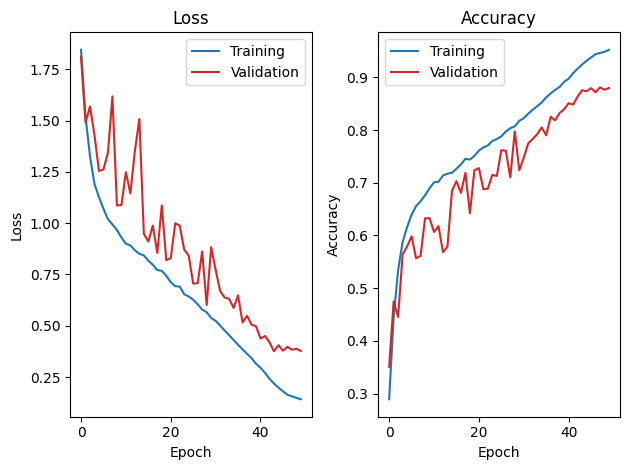

In [ ]:
import os
import time

import torch
from torch import nn, optim
from tqdm.notebook import tqdm

reset_seed(10)


def train_one_epoch(model, loader, criterion, optimizer, device=DEFAULT_DEVICE):
    running_loss = 0
    total, correct = 0, 0

    loop = tqdm(loader, desc="Training", leave=True)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(
            loss=running_loss / (total / images.shape[0]), accuracy=correct / total
        )

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


def train(
    model,
    trainloader,
    valloader,
    criterion,
    optimizer,
    scheduler=None,
    epochs=1,
    save_path=None,
    device=DEFAULT_DEVICE,
):
    model = model.to(device)

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    epoch_loop = tqdm(range(epochs), desc="Epochs", leave=True)

    for epoch in epoch_loop:
        model.train()
        _train_loss, _train_acc = train_one_epoch(
            model, trainloader, criterion, optimizer
        )
        train_loss.append(_train_loss)
        train_acc.append(_train_acc)

        model.eval()
        _val_loss, _val_acc, _ = evaluate(model, valloader, criterion)
        val_loss.append(_val_loss)
        val_acc.append(_val_acc)

        print(f"Epoch {epoch + 1:2d}/{epochs}", end="  ")
        if scheduler is not None:
            print(f"lr={scheduler.get_last_lr()[0]:.2e}", end=", ")
        print(f"train_loss={_train_loss:.4f}, val_loss={_val_loss:.4f}", end=", ")
        print(f"train_acc={_train_acc:.4f}, val_acc={_val_acc:.4f}")

        if _val_acc >= max(val_acc):
            save_model(model, save_path, existed="overwrite")

        if scheduler is not None:
            scheduler.step()

        epoch_loop.set_postfix(
            train_loss=_train_loss,
            val_loss=_val_loss,
            train_acc=_train_acc,
            val_acc=_val_acc,
        )

    return train_loss, train_acc, val_loss, val_acc


def main(epochs, network, dataset, name=None):
    dataset = dataset.lower()
    if name is None:
        name = f"{dataset}/{network.__name__.lower()}"

    t = time.time()
    trainloader, valloader, testloader = DATALOADERS[dataset](batch_size=64)
    in_channels, in_size = trainloader.dataset[0][0].shape[:2]
    model = network(in_channels, in_size).to(DEFAULT_DEVICE)
    #########Implement your code here##########
    #Loss function
    criterion = nn.CrossEntropyLoss()
    #Optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    #Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    ##########################################
    train_loss, train_acc, val_loss, val_acc = train(
        model,
        trainloader,
        valloader,
        criterion,
        optimizer,
        scheduler,
        epochs,
        save_path=f"weights/{name}.pt",
    )

    test_loss, test_accuracy, _ = evaluate(model.eval(), testloader, criterion)
    print(f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}")
    print(f"Model size: {os.path.getsize(f'weights/{name}.pt') / 1e6:.2f} MB")

    plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, f"figure/{name}.png")
    print(f"Time: {time.time() - t:.2f}s")


if __name__ == "__main__":
    for network in [VGG]:
        """ You can adjust the number of epochs """
        EPOCHS = 50
        main(epochs=EPOCHS, network=network, dataset="cifar10")

### PTQ on VGG Model

#### You can refer to 'Quantization in Practice' in the lab material.



In [30]:
import os
import torch
from torch import nn
import torch.ao.quantization as tq

# Reset random seed for reproducibility
def reset_seed(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

reset_seed(0)

######### Implement Calibration Function ##########
""" Calibration Method """
def calibrate(model, loader, device="cpu"):
    model.eval().to(device)
    with torch.no_grad():
        for x, _ in loader:
            model(x.to(device))
            break  # Only run one batch for calibration
###########################################

def main(network, verbose=True):
    ######### Implement Quantization Workflow ##########
    """ Load Dataset for Calibration """
    dataset = "cifar10"  # Replace with actual dataset
    backend = "power2"  # Replace with actual backend
    model_path = "./weight_fp32.pt"
    *_, test_loader = DATALOADERS[dataset](batch_size=1)

    """ Load Pretrained Model """
    model = network(in_channels=3, in_size=32, num_classes=10).eval().cpu()
    model.load_state_dict(torch.load(model_path))

    """ Fuse Modules """
    model.fuse_modules()
    summary(model, (3, 32, 32), device="cpu")

    """ Configure Quantization """
    model = tq.QuantWrapper(model)
    model.qconfig = CustomQConfig.POWER2.value  # Use Power-of-Two Observer
    print(f"Quantization backend: {model.qconfig}")

    """ Insert Observer """
    tq.prepare(model, inplace=True)

    """ Apply Calibration """
    calibrate(model, test_loader, "cpu")

    """ Apply Quantization """
    tq.convert(model.cpu(), inplace=True)

    """ Save Model """
    save_model(model, "./weight_int8.pt", existed="overwrite")
    ###########################################

if __name__ == "__main__":
    main(network=VGG, verbose=True)

Files already downloaded and verified
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
          Identity-3           [-1, 32, 32, 32]               0
          Identity-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
              ReLU-7           [-1, 64, 16, 16]               0
          Identity-8           [-1, 64, 16, 16]               0
          Identity-9           [-1, 64, 16, 16]               0
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
             ReLU-12            [-1, 128, 8, 8]               0
         Identity-13       

C:\Users\章元豪\AppData\Local\Temp\ipykernel_14736\4156689222.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


### Evaluate Quantized Model


In [31]:
import os
from torch import nn
import torch.ao.quantization as tq

reset_seed(0)

def main():
    dataset = 'cifar10'
    backend = 'power2'
    model_path = 'weight_int8.pt'

    *_, test_loader = DATALOADERS[dataset](batch_size=1000)
    in_channels, in_size = test_loader.dataset[0][0].shape[:2]
    if backend:
        qconfig = CustomQConfig[backend.upper()].value
        fuse_modules = True
    else:
        qconfig = None
        fuse_modules = False
    model = load_model(VGG(in_channels, in_size), model_path, qconfig=qconfig, fuse_modules=fuse_modules)
    print(model)

    device = "cpu" if backend else DEFAULT_DEVICE
    criterion = nn.CrossEntropyLoss()
    test_loss, test_accuracy, _ = evaluate(
        model.to(device), test_loader, criterion, device=device
    )
    print(
        f"Test: loss={test_loss:.4f}, accuracy={test_accuracy:.4f}, size={os.path.getsize(model_path) / 1e6}MB"
    )


if __name__ == "__main__":
    main()

Files already downloaded and verified
Files already downloaded and verified
Fusing modules
Model loaded from weight_int8.pt (0.673672 MB)
QuantWrapper(
  (quant): Quantize(scale=tensor([0.0156]), zero_point=tensor([128]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (module): VGG(
    (conv1): Sequential(
      (0): QuantizedConvReLU2d(3, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.03125, zero_point=128, padding=(1, 1))
      (1): Identity()
      (2): Identity()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): QuantizedConvReLU2d(32, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.015625, zero_point=128, padding=(1, 1))
      (1): Identity()
      (2): Identity()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.0078125, zero_point=128, padding=(1, 1))
  

C:\Users\章元豪\AppData\Local\Temp\ipykernel_14736\2912952992.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename, map_location=devi

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Test: loss=0.3881, accuracy=0.8800, size=0.673672MB
